In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import math
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

LOADING DATA

In [5]:
df_cpu = pd.read_csv('../../model_data/cpuProductData.csv')
df_gpu = pd.read_csv('../../model_data/gpuProductData.csv')

FUNCTIONS TO BE UTILISED THROUGHOUT

In [6]:
def clean_data(data, modelsDir):

    # Loading file with models
    models = pd.read_csv(modelsDir)
    models['model'] = models['model'].str.upper()

    # Renaming product model for consistency
    data['model'] = data['model'].str.upper()
    data['brand'] = data['brand'].str.upper()
    data['type'] = data['type'].str.upper()
    data['availability'] = data['availability'].str.upper()

    for dt in data.itertuples():
        for model in models.itertuples():
            if dt.model.find(str(model.model)) != -1:
                data.at[dt.Index, 'model'] = model.Index
                continue

    # Removing models which dont havent been renamed
    data = data.replace('', np.nan)
    data = data.dropna()


In [7]:
def encode_data(data):
    def split_date(date):
        year = int(date[:4])
        month = int(date[4:6])
        day_month = int(date[6:8])
        week = datetime.date(year, month, day_month).isocalendar()[1]
        day_week = datetime.date(year, month, day_month).isocalendar()[2]
        day_year = day_week * week
        quarter = math.ceil(float(month)/3)
        return year, month, quarter, week, day_year, day_month, day_week
    
    # Splitting data into diff components
    
    for dt in data.itertuples():
        year, month, quarter, week, day_year, day_month, day_week = split_date(str(dt.date))
        data.at[dt.Index, 'year'] = year
        data.at[dt.Index, 'month'] = month
        data.at[dt.Index, 'quarter'] = quarter
        data.at[dt.Index, 'week'] = week
        data.at[dt.Index, 'day_year'] = day_year
        data.at[dt.Index, 'day_month'] = day_month
        data.at[dt.Index, 'day_week'] = day_week    

    del data['date']

    label_encoder = LabelEncoder()
    data['brand'] = label_encoder.fit_transform(data['brand'])
    data['model'] = label_encoder.fit_transform(data['model'])
    data['type'] = label_encoder.fit_transform(data['type'])

    enc_brand = pd.get_dummies(data.brand, prefix='brand')
    del data['brand']
    data = pd.concat([data, enc_brand], axis=1)

    enc_model = pd.get_dummies(data.model, prefix='model')
    del data['model']
    data = pd.concat([data, enc_model], axis=1)

    enc_type = pd.get_dummies(data.type, prefix='type')
    del data['type']
    data = pd.concat([data, enc_type], axis=1)

    avail = set(data['availability'].str.upper())
    avail = pd.DataFrame(avail)
    avail = avail.rename(columns={0: 'availability'})

    for av in avail.itertuples():
        data.loc[data['availability'].str.upper() == av.availability, 'availability'] = av.Index
    
    return data

In [8]:
def get_sets(data):

    # shuffling data

    index = [i for i in range(data.shape[0])]
    random.shuffle(index)
    data = data.set_index([index]).sort_index()
    
    # split between train and test
    
    Y = data[['availability']]
    Y = np.array(Y).astype('float32')
    del data['availability']
    del data['model']
    X = np.array(data).astype('float32')
    x_train, x_test, y_train, y_test = train_test_split(X,Y)

    return x_train, x_test, y_train, y_test

MODEL IMPLEMENTATION

In [9]:
clean_data(df_cpu, '../../model_data/cpuModels.csv')
clean_data(df_gpu, '../../model_data/gpuModels.csv')
df_prods = df_cpu.append(df_gpu, ignore_index=True)

In [10]:
df_prods = encode_data(df_prods)

In [11]:
train_set = df_prods.sample(frac=0.8, random_state=5)
test_set = df_prods.drop(train_set.index)

x_train = train_set.copy()
x_test = test_set.copy()

y_train = x_train.pop('availability')
y_test = x_test.pop('availability')

In [12]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

y_test_labels = y_test.copy()

y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(x_train)
x_train = scaler_x.transform(x_train)

scaler_x.fit(x_test)
x_test = scaler_x.transform(x_test)

scaler_y.fit(y_train)
y_train = scaler_y.transform(y_train)

scaler_y.fit(y_test)
y_test = scaler_y.transform(y_test)


In [13]:
data_length = len(x_train[0])

model = keras.Sequential([
    layers.Dense(data_length + 1, input_dim=data_length, kernel_initializer='normal', activation='relu'),
    layers.Dense(data_length*8, activation='relu'),
    layers.Dense(data_length*3, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

In [14]:
model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.005, momentum=0.9, nesterov=True),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 158)               24964     
_________________________________________________________________
dense_1 (Dense)              (None, 1256)              199704    
_________________________________________________________________
dense_2 (Dense)              (None, 471)               592047    
_________________________________________________________________
dropout (Dropout)            (None, 471)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 944       
Total params: 817,659
Trainable params: 817,659
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(
    x_train,
    y_train,
    epochs=500,
    verbose=0,
    batch_size=150,
    shuffle=True,
    validation_split=0.2
)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.621065,0.705596,0.582554,0.723729,0
1,0.580158,0.722764,0.573199,0.723729,1
2,0.570001,0.722764,0.564112,0.723729,2
3,0.561070,0.722764,0.555002,0.723729,3
4,0.551395,0.722764,0.545977,0.723729,4


In [16]:
test_predictions = model.predict(x_test)
test_predictions = scaler_y.inverse_transform(test_predictions)

In [17]:
metrics = model.evaluate(x_test, y_test)


47/47 [==============================] - 0s 4ms/step - loss: 0.5427 - accuracy: 0.8847


In [18]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [PRICE]')
    plt.legend()
    plt.grid(True)

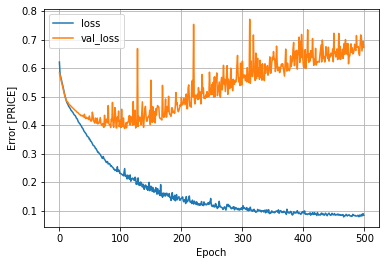

In [19]:
plot_loss(history)

In [20]:
y_test

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [30]:
test_preds = [0 if x[0] >= x[1] else 1 for x in test_predictions]

[]

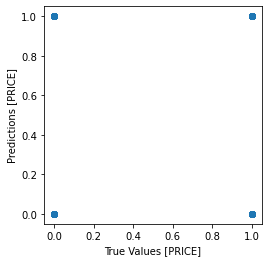

In [31]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_preds)
plt.xlabel('True Values [PRICE]')
plt.ylabel('Predictions [PRICE]')
plt.plot()

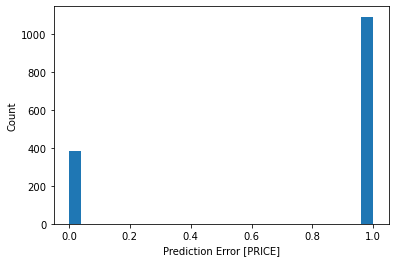

In [32]:
error = test_preds = y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [PRICE]')
_ = plt.ylabel('Count')

In [33]:
model.save('../../trained_models/avail_prediction.h5')